### Import all necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

from skimage.io import imread
from os import listdir

#special thanks to https://www.kaggle.com/allunia/breast-cancer/notebook for this beautiful visualization

### Exploring the data structure

In [2]:
files = listdir("../breast_cancer_data/")
print(len(files))

280


In [3]:
files[0:10]

['12878',
 '15839',
 '9227',
 '16166',
 '12241',
 '12883',
 '12876',
 '8916',
 '15840',
 '13022']

### How many patients do we have?

In [4]:
base_path = "../breast_cancer_data/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder) # Almost 279 patients

279

### How many patches do we have in total?

In [5]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [6]:
total_images #Ok, roughly 280000 images

277524

### Storing the image_path, patient_id and the target

In [7]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,12878,../breast_cancer_data/IDC_regular_ps50_idx5/12...,0
1,12878,../breast_cancer_data/IDC_regular_ps50_idx5/12...,0
2,12878,../breast_cancer_data/IDC_regular_ps50_idx5/12...,0
3,12878,../breast_cancer_data/IDC_regular_ps50_idx5/12...,0
4,12878,../breast_cancer_data/IDC_regular_ps50_idx5/12...,0


# Exploratory analysis ¶
What do we know about our data?

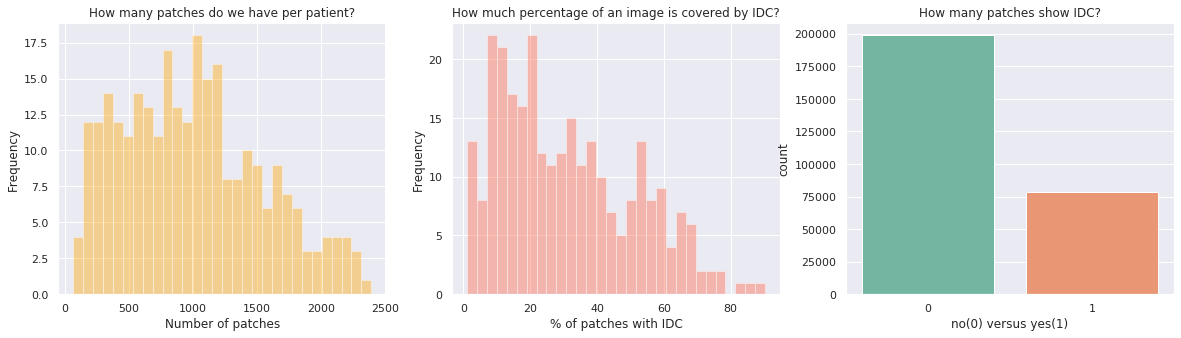

In [8]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights¶
1. The number of image patches per patient varies a lot! This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients.'
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. Does a tissue slice per patient cover the whole region of interest?
3. The classes of IDC versus no IDC are imbalanced. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

### Looking at healthy and cancer patches

In [9]:
data.target = data.target.astype(np.int)

In [10]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

#### Cancer Patches

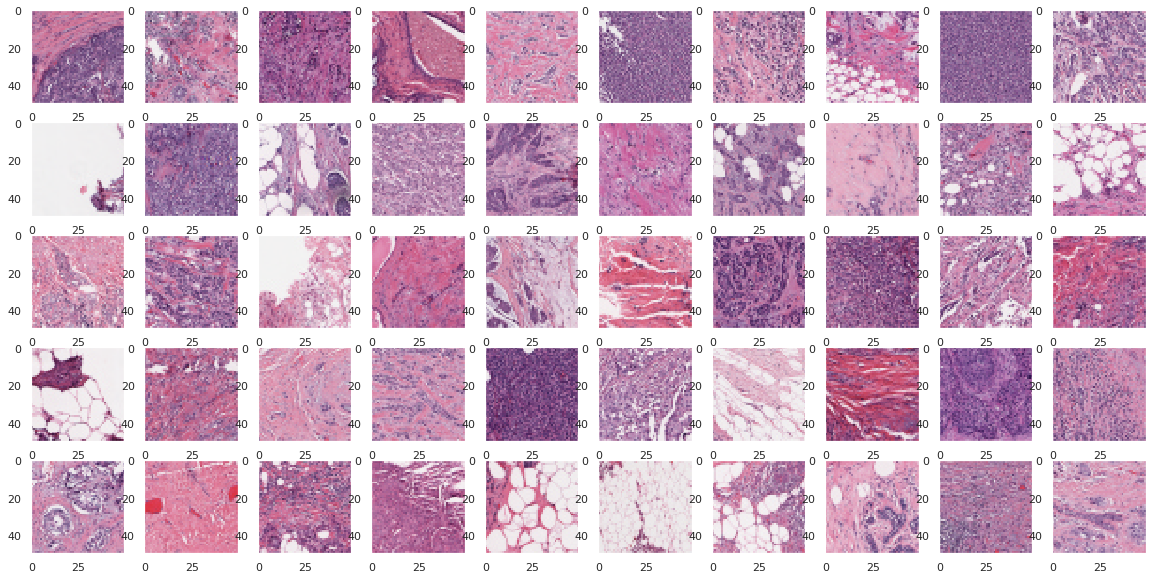

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Healthy patches

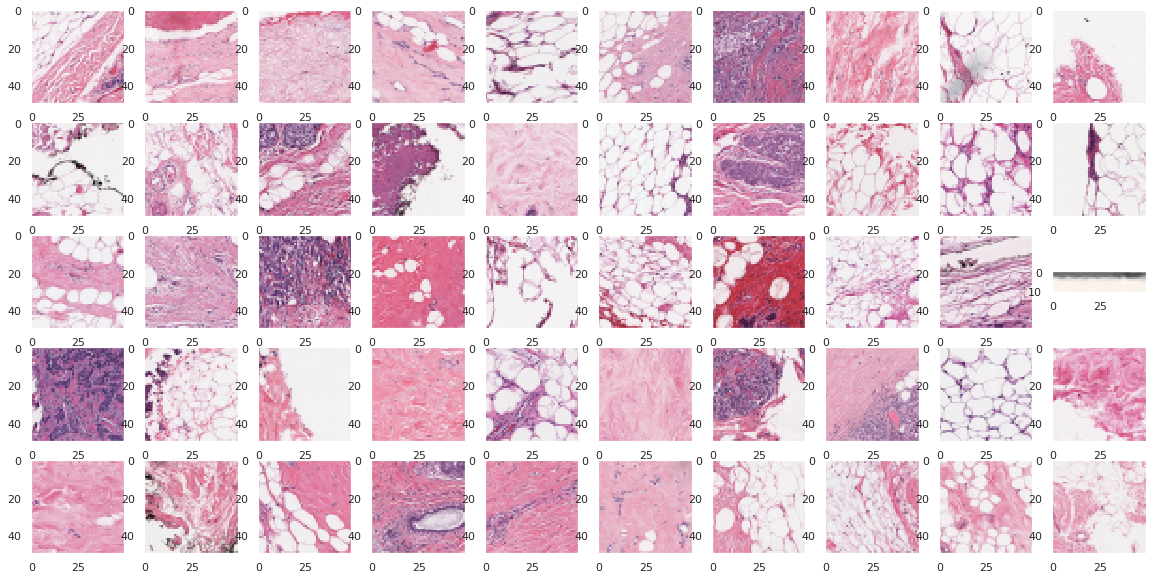

In [12]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Visualising the breast tissue ¶
This part is a bit tricky! We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [13]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [14]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,2251,951,0,../breast_cancer_data/IDC_regular_ps50_idx5/12...
1,2501,851,0,../breast_cancer_data/IDC_regular_ps50_idx5/12...
2,2551,901,0,../breast_cancer_data/IDC_regular_ps50_idx5/12...
3,2101,1951,0,../breast_cancer_data/IDC_regular_ps50_idx5/12...
4,1601,2551,0,../breast_cancer_data/IDC_regular_ps50_idx5/12...


### Binary target visualisation per tissue slice 
Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

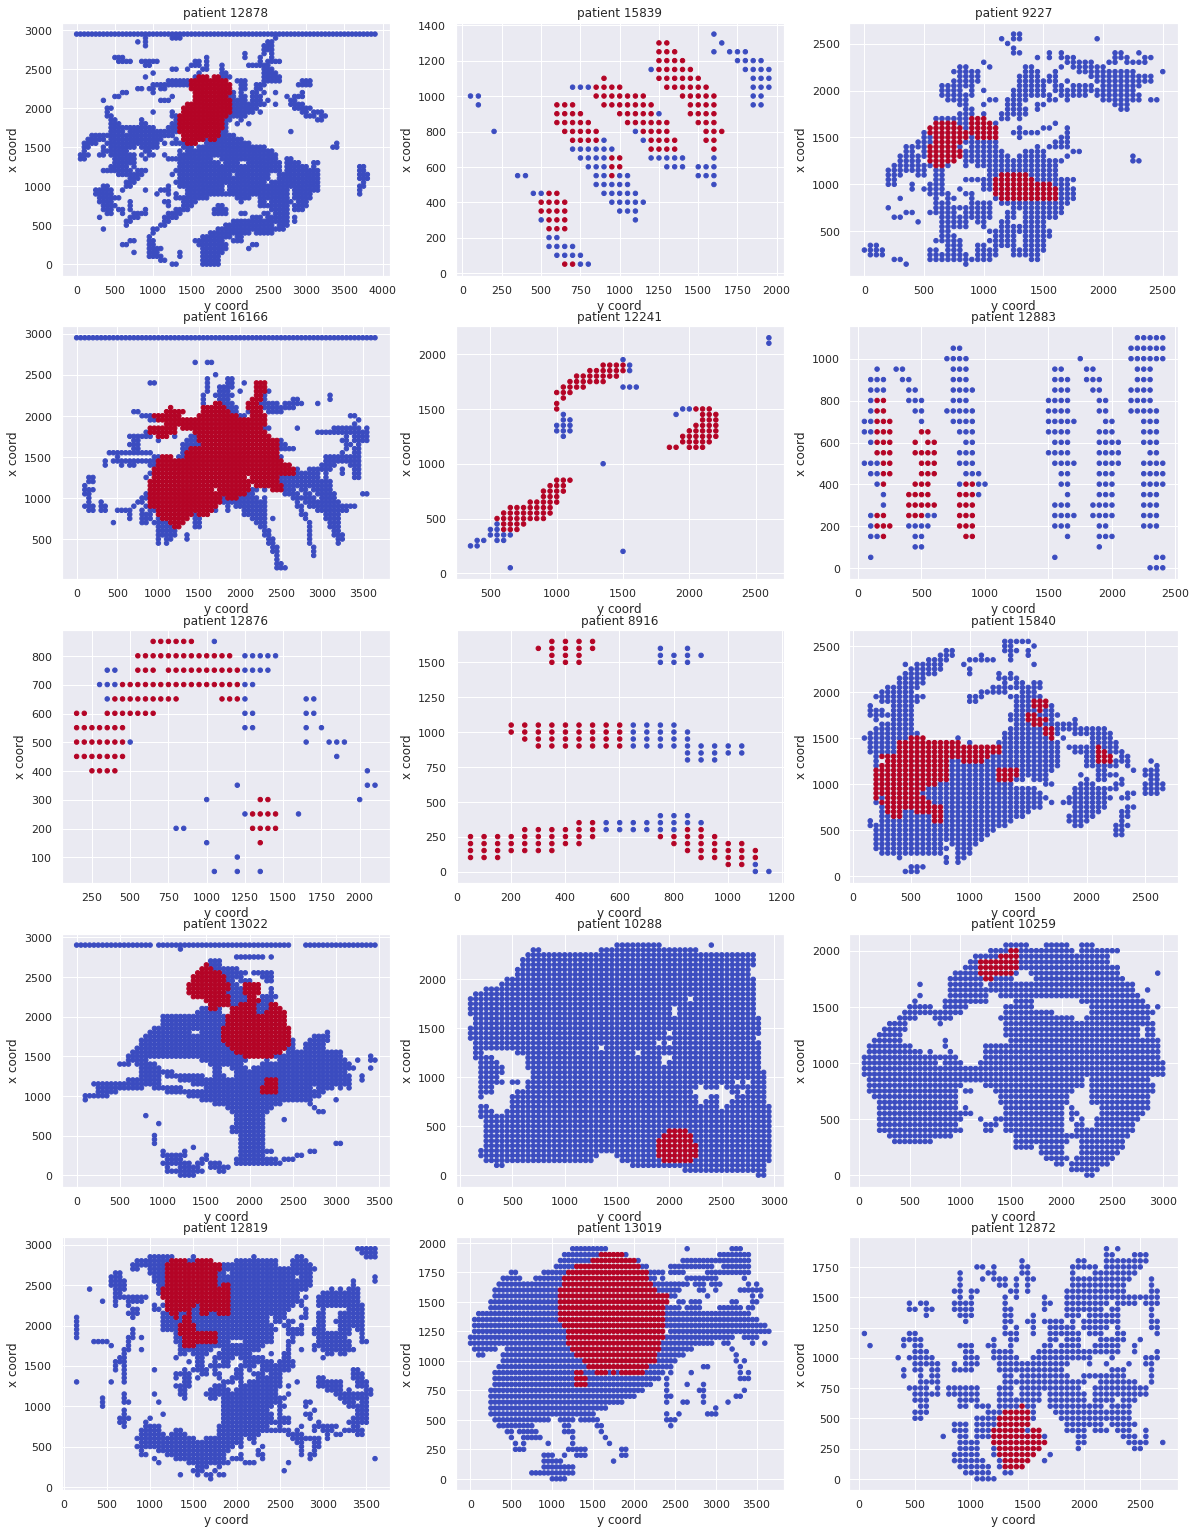

In [15]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights
Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

### Visualising the breast tissue images 
Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets).

In [16]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

Let's use an example patient with id 13616:

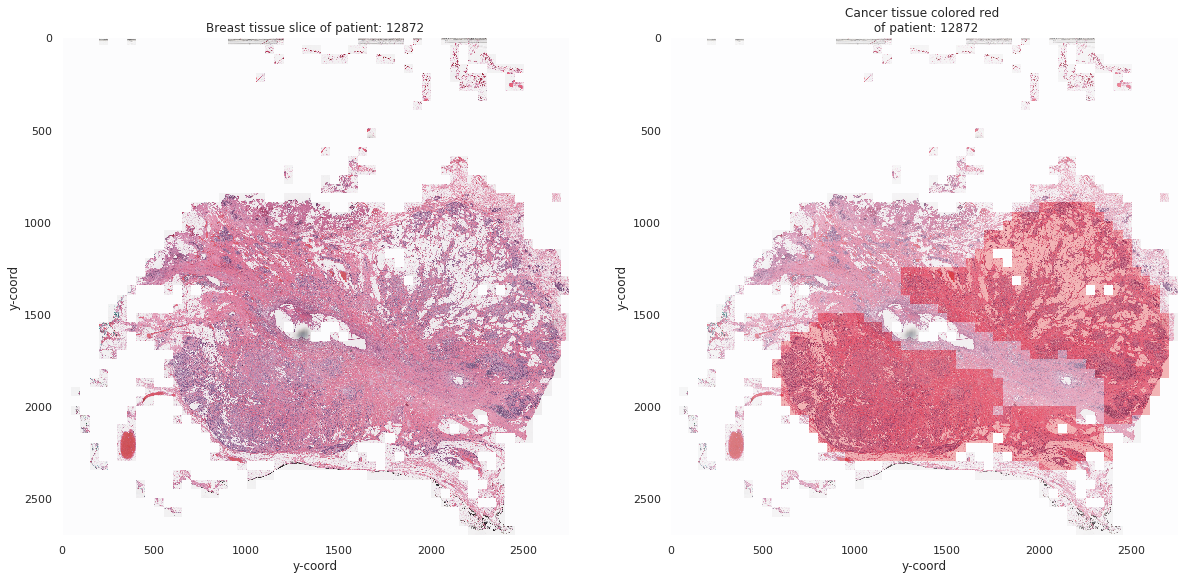

In [17]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);


### Insights
1. The tissue on the left is shown without target information.
2. The image on the right shows the same tissue but cancer is stained with intensive red color.
3. Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
4. But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!
